# Sherlock2Vector

In [4]:
from __future__ import absolute_import, division, print_function

In [5]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [6]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [8]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [9]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmetihsan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmetihsan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Metnin Hazırlanması

**Kitaplar klasörden okunur**

In [10]:
book_filenames = sorted(glob.glob("data1/sherlockfull.txt"))

In [11]:
print("Found books:")
book_filenames

Found books:


['data1/sherlockfull.txt']

**Bütün kitaplar tek bir yerde birleştirilir**

In [12]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data1/sherlockfull.txt'...
Corpus is now 3585270 characters long



**NLTK Kütüphanesi ile anlama etkisi olmayan kelimeler temizlenir**

In [13]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [14]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [15]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [16]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [17]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 671,891 tokens


## Word2Vec Oluşturulması ve Eğitilmesi

In [18]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [19]:
sherlock2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [20]:
sherlock2vec.build_vocab(sentences)

2020-01-02 19:03:49,978 : INFO : collecting all words and their counts
2020-01-02 19:03:49,980 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-02 19:03:50,019 : INFO : PROGRESS: at sentence #10000, processed 127184 words, keeping 10617 word types
2020-01-02 19:03:50,069 : INFO : PROGRESS: at sentence #20000, processed 344950 words, keeping 15852 word types
2020-01-02 19:03:50,110 : INFO : PROGRESS: at sentence #30000, processed 516300 words, keeping 18602 word types
2020-01-02 19:03:50,149 : INFO : collected 21122 word types from a corpus of 671891 raw words and 38967 sentences
2020-01-02 19:03:50,150 : INFO : Loading a fresh vocabulary
2020-01-02 19:03:50,252 : INFO : effective_min_count=3 retains 10255 unique words (48% of original 21122, drops 10867)
2020-01-02 19:03:50,253 : INFO : effective_min_count=3 leaves 657962 word corpus (97% of original 671891, drops 13929)
2020-01-02 19:03:50,291 : INFO : deleting the raw counts dictionary of 21122 items

In [21]:
print("Word2Vec vocabulary length:", len(sherlock2vec.wv.vocab))

Word2Vec vocabulary length: 10255


**Start training, this might take a minute or two...**

In [22]:
sherlock2vec.train(sentences,total_examples=sherlock2vec.corpus_count, epochs=sherlock2vec.iter)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.
2020-01-02 19:03:52,818 : INFO : training model with 4 workers on 10255 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2020-01-02 19:03:53,856 : INFO : EPOCH 1 - PROGRESS: at 30.38% examples, 119390 words/s, in_qsize 8, out_qsize 0
2020-01-02 19:03:54,882 : INFO : EPOCH 1 - PROGRESS: at 54.70% examples, 129557 words/s, in_qsize 7, out_qsize 0
2020-01-02 19:03:55,891 : INFO : EPOCH 1 - PROGRESS: at 95.72% examples, 151332 words/s, in_qsize 3, out_qsize 1
2020-01-02 19:03:55,892 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-02 19:03:55,930 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-02 19:03:55,960 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-02 19:0

(2413394, 3359455)

**Eğitilen modelin Kaydedilmesi**

In [23]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [24]:
sherlock2vec.save(os.path.join("trained", "sherlock2vec.w2v"))

2020-01-02 19:04:06,835 : INFO : saving Word2Vec object under trained/sherlock2vec.w2v, separately None
2020-01-02 19:04:06,844 : INFO : not storing attribute vectors_norm
2020-01-02 19:04:06,846 : INFO : not storing attribute cum_table
2020-01-02 19:04:07,207 : INFO : saved trained/sherlock2vec.w2v


## Kaydedilen Modelin Yüklenmesi.

In [25]:
sherlock2vec = w2v.Word2Vec.load(os.path.join("trained", "sherlock2vec.w2v"))

2020-01-02 19:04:07,219 : INFO : loading Word2Vec object from trained/sherlock2vec.w2v
2020-01-02 19:04:07,417 : INFO : loading wv recursively from trained/sherlock2vec.w2v.wv.* with mmap=None
2020-01-02 19:04:07,418 : INFO : setting ignored attribute vectors_norm to None
2020-01-02 19:04:07,418 : INFO : loading vocabulary recursively from trained/sherlock2vec.w2v.vocabulary.* with mmap=None
2020-01-02 19:04:07,419 : INFO : loading trainables recursively from trained/sherlock2vec.w2v.trainables.* with mmap=None
2020-01-02 19:04:07,421 : INFO : setting ignored attribute cum_table to None
2020-01-02 19:04:07,423 : INFO : loaded trained/sherlock2vec.w2v


### TSNE ile Eğitilen Modelin Görselleştirilmesi

In [26]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [27]:
all_word_vectors_matrix = sherlock2vec.wv.vectors

**Metinde geçen kelimelerin tsne ile koordinatlarının belirlenmesi**

In [28]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [29]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[sherlock2vec.wv.vocab[word].index])
            for word in sherlock2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [45]:
points.head(11)

,word,x,y
0,The,-73.200302,8.617516
1,Sherlock,-48.974159,-31.746822
2,Holmes,33.123737,-14.442449
3,Arthur,9.512790,-36.815720
4,This,-29.792664,-44.799397
5,text,-0.242749,-14.871414
6,is,-26.207552,-57.082630
7,provided,-6.683470,-47.581478
8,to,10.250374,-64.521950
9,you,1.984490,-68.938904


In [31]:
sns.set_context("poster")

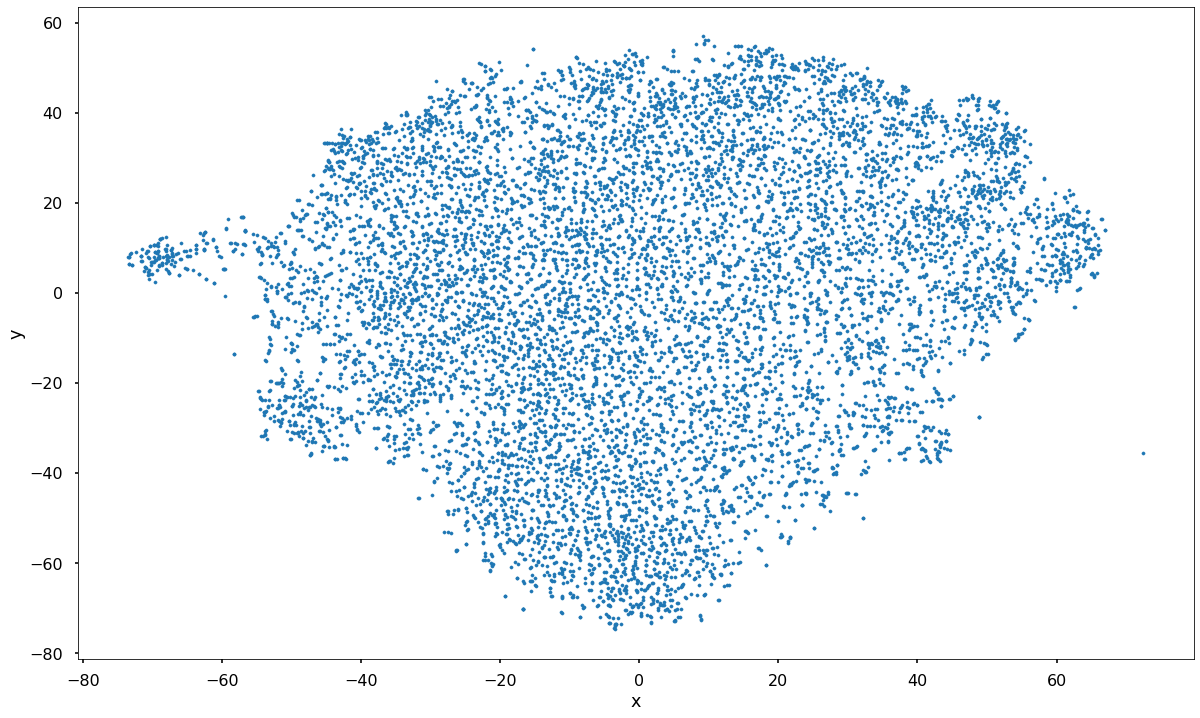

In [32]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [33]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

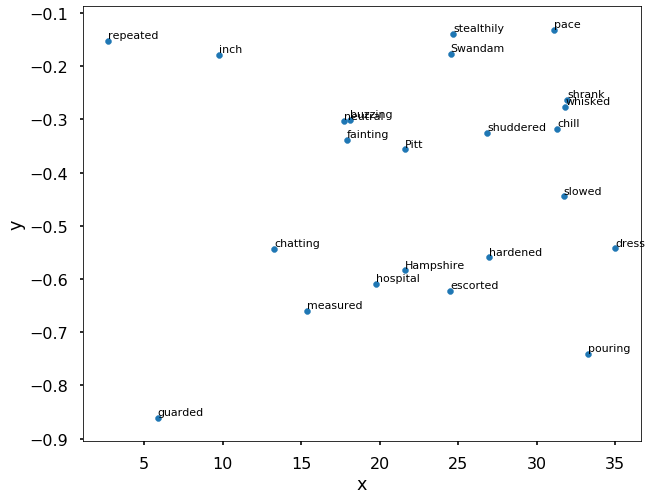

In [46]:
plot_region(x_bounds=(-0.1, 35.2), y_bounds=(-0.9, -0.1))

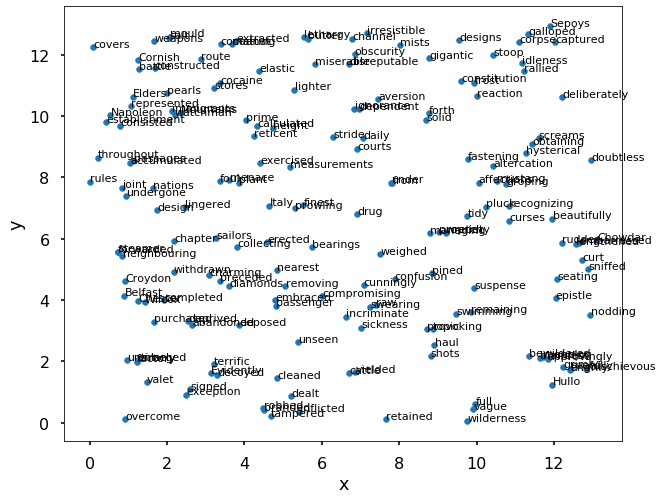

In [47]:
plot_region(x_bounds=(0, 13.25), y_bounds=(0, 13.25))

### Verilen kelimeler arasında anlamsal ilişkilerin keşfedilmesi

In [36]:
sherlock2vec.most_similar("Arthur")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-01-02 19:12:32,093 : INFO : precomputing L2-norms of word weight vectors


[('Bannister', 0.8855927586555481),
 ('Professor', 0.8855826258659363),
 ('Trevor', 0.8809126019477844),
 ('unhappy', 0.8779938220977783),
 ('Gorgiano', 0.8779351711273193),
 ('Poor', 0.8755863308906555),
 ('delivered', 0.8729146718978882),
 ('thus', 0.8722497224807739),
 ('assistant', 0.8712184429168701),
 ('Duke', 0.8709868788719177)]

In [37]:
sherlock2vec.most_similar("Holmes")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Hopkins', 0.722963809967041),
 ('Gregson', 0.7061948776245117),
 ('gravely', 0.7050148844718933),
 ('McMurdo', 0.7001247406005859),
 ('MacDonald', 0.6998462080955505),
 ('inspector', 0.6965806484222412),
 ('Lestrade', 0.6924146413803101),
 ('Athelney', 0.690698504447937),
 ('Thaddeus', 0.6878268718719482),
 ('Barker', 0.6847513318061829)]

In [38]:
sherlock2vec.most_similar("Sherlock")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('MacDonald', 0.8078039884567261),
 ('gravely', 0.8068252801895142),
 ('Gregson', 0.8002640008926392),
 ('Inspector', 0.7956593036651611),
 ('Athelney', 0.7939716577529907),
 ('thoughtfully', 0.7812885046005249),
 ('Excellent', 0.7801499366760254),
 ('Yard', 0.7764827609062195),
 ('heavens', 0.7712293267250061),
 ('Mason', 0.769390344619751)]

In [39]:
sherlock2vec.most_similar("Rucastle")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Warren', 0.9072225689888),
 ('Windibank', 0.9045333862304688),
 ('Cunningham', 0.8974963426589966),
 ('Duncan', 0.8966517448425293),
 ('Harrison', 0.891179621219635),
 ('Angel', 0.8910092115402222),
 ('Melas', 0.8891610503196716),
 ('Forrester', 0.8833848237991333),
 ('Pinner', 0.8831977844238281),
 ('Merrilow', 0.8817765712738037)]

In [41]:
sherlock2vec.most_similar("Mason")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('White', 0.9738744497299194),
 ('Pycroft', 0.9409273862838745),
 ('Culverton', 0.9141607880592346),
 ('Wilson', 0.9134565591812134),
 ('Good', 0.8992170095443726),
 ('Excellent', 0.8989508152008057),
 ('Baynes', 0.8973495364189148),
 ('Holder', 0.888814389705658),
 ('Jabez', 0.8868640661239624),
 ('Melas', 0.8848665952682495)]

**Kelime çiftleri arasındaki pozitif-negatif ilişkinin keşfedilmesi**

In [ ]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = potter2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [ ]:
nearest_similarity_cosmul("Sherlock", "Holmes", "Ron")
nearest_similarity_cosmul("Ron", "Potter", "Hermione")
nearest_similarity_cosmul("Dumbledore", "McGonagall", "Sirius")

In [ ]:
burada sadece analiz yapılmaktadır, modelin eğitilmesi gerekmektedir.

In [ ]:
data = pd.read("data/sherlockfull.txt")